# Adding new passbands to PHOEBE

In this tutorial we will show you how to add your own passband to PHOEBE. Adding a passband involves:

* providing a passband transmission function;
* defining and registering parameters of the passband;
* computing blackbody response for the passband;
* \[optional\] computing Castelli & Kurucz (2004) response for the passband;
* \[optional\] computing Castelli & Kurucz (2004) limb darkening coefficients;
* \[optional\] computing Castelli & Kurucz (2004) limb darkening integrals;
* \[optional\] if the passband is one of the passbands included in the Wilson-Devinney code, importing the WD response; and
* saving the generated passband file.



Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [ ]:
#!pip install -I "phoebe>=2.3,<2.4"

I don't care about the details, just show/remind me how it's done
-------------------------------------------------------------------

Makes sense, and we don't judge: you want to get to science. Provided that you have the passband transmission file available and the ck2004 database already downloaded, the sequence that will generate/register a new passband is:

In [ ]:
import phoebe
from phoebe import u

# Register a passband:
pb = phoebe.atmospheres.passbands.Passband(
    ptf='my_passband.ptf', pbset='Custom', pbname='mypb',
    effwl=330., wlunits=u.nm, calibrated=True,
    reference='A completely made-up passband published in Nowhere (2017)', version=1.0,
    comments='This is my first custom passband')

# Blackbody response:
pb.compute_blackbody_response()

# Castelli & Kurucz (2004) response:
pb.compute_ck2004_response(path='ck2004i')
pb.compute_ck2004_intensities(path='ck2004i')
pb.compute_ck2004_ldcoeffs()
pb.compute_ck2004_ldints()

# Wilson-Devinney response:
pb.import_wd_atmcof('atmcofplanck.dat', 'atmcof.dat', 22)

# Save the passband:
pb.save('my_passband.pb')

Getting started
-----------------

Let us start by importing phoebe, numpy and matplotlib:

In [1]:
%matplotlib inline
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='WARNING')

Passband transmission function
-----------------------------------

The passband transmission function is typically a user-provided two-column file. The first column is wavelength, and the second column is passband transmission. For the purposes of this tutorial, we will simulate the passband as a uniform box.

In [2]:
wl = np.linspace(300, 360, 61)
ptf = np.zeros(len(wl))
ptf[(wl>=320) & (wl<=340)] = 1.0

Let us plot this simulated passband transmission function to see what it looks like:

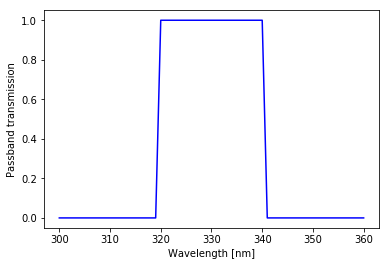

In [3]:
plt.xlabel('Wavelength [nm]')
plt.ylabel('Passband transmission')
plt.plot(wl, ptf, 'b-')
plt.show()

Let us now save these data in a file that we will use to register a new passband.

In [4]:
np.savetxt('my_passband.ptf', np.vstack((wl, ptf)).T)

Registering a passband
-------------------------

The first step in introducing a new passband into PHOEBE is registering it with the system. We use the [Passband](../api/phoebe.atmospheres.passbands.Passband.md) class for that.

In [5]:
pb = phoebe.atmospheres.passbands.Passband(
    ptf='my_passband.ptf',
    pbset='Custom',
    pbname='mypb',
    effwl=330.,
    wlunits=u.nm,
    calibrated=True,
    reference='A completely made-up passband published in Nowhere (2017)',
    version=1.0,
    comments='This is my first custom passband')

The first argument, `ptf`, is the passband transmission file we just created. Of course, you would provide an actual passband transmission function that comes from a respectable source rather than this silly tutorial.

The next two arguments, `pbset` and `pbname`, should be taken in unison. The way PHOEBE refers to passbands is a `pbset`:`pbname` string, for example `Johnson:V`, `Cousins:Rc`, etc. Thus, our fake passband will be `Custom:mypb`.

The following two arguments, `effwl` and `wlunits`, also come as a pair. PHOEBE uses effective wavelength to apply zero-level passband corrections when better options (such as model atmospheres) are unavailable. Effective wavelength is a transmission-weighted average wavelength in the units given by `wlunits`.

The `calibrated` parameter instructs PHOEBE whether to take the transmission function as calibrated, i.e. the flux through the passband is absolutely calibrated. If set to `True`, PHOEBE will assume that absolute intensities computed using the passband transmission function do not need further calibration. If `False`, the intensities are considered as scaled rather than absolute, i.e. correct to a scaling constant. Most modern passbands provided in the recent literature are calibrated.

The `reference` parameter holds a reference string to the literature from which the transmission function was taken from. It is common that updated transmission functions become available, which is the point of the `version` parameter. If there are multiple versions of the transmission function, PHOEBE will by default take the largest value, or the value that is explicitly requested in the filter string, i.e. `Johnson:V:1.0` or `Johnson:V:2.0`.

Finally, the `comments` parameter is a convenience parameter to store any additional pertinent information.

Computing blackbody response
--------------------------------

To significantly speed up calculations, passband coefficients are stored in lookup tables instead of computing the intensities over and over again on the fly. Computed passband tables are tagged in the `content` property of the class:

In [6]:
print pb.content

[]


Since we have not computed any tables yet, the list is empty for now. Blackbody functions for computing the lookup tables are built into PHOEBE and you do not need any auxiliary files to generate them. The lookup tables are defined for effective temperatures between 300K and 500,000K. To compute the blackbody response, issue:

In [7]:
pb.compute_blackbody_response()

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Checking the `content` property again shows that the table has been successfully computed:

In [8]:
print pb.content

['blackbody']


We can now test-drive the blackbody lookup table we just created. For this we will use a low-level `Passband` class method that computes normal emergent passband intensity, `Inorm()`. For the sake of simplicity, we will turn off limb darkening by setting `ld_func` to `'linear'` and `ld_coeffs` to `'[0.0]'`:

In [9]:
print pb.Inorm(Teff=5772, atm='blackbody', ld_func='linear', ld_coeffs=[0.0])

[  1.59532162e+13]


Let us now plot a range of temperatures, to make sure that normal emergent passband intensities do what they are supposed to do. While at it, let us compare what we get for the Johnson:V passband.

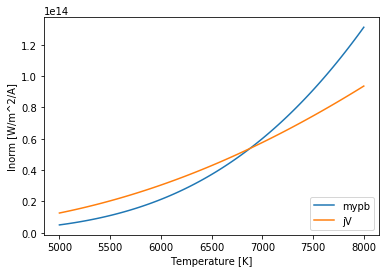

In [10]:
jV = phoebe.get_passband('Johnson:V')
teffs = np.linspace(5000, 8000, 100)
plt.xlabel('Temperature [K]')
plt.ylabel('Inorm [W/m^2/A]')
plt.plot(teffs, pb.Inorm(teffs, atm='blackbody', ld_func='linear', ld_coeffs=[0.0]), label='mypb')
plt.plot(teffs, jV.Inorm(teffs, atm='blackbody', ld_func='linear', ld_coeffs=[0.0]), label='jV')
plt.legend(loc='lower right')
plt.show()

This makes perfect sense: Johnson V transmission function is wider than our boxed transmission function, so intensity in the V band is larger the lower temperatures. However, for the hotter temperatures the contribution to the UV flux increases and our box passband with a perfect transmission of 1 takes over.

Computing Castelli & Kurucz (2004) response
-------------------------------------------------

For any real science you will want to generate model atmosphere tables. The default choice in PHOEBE are the models computed by Fiorella Castelli and Bob Kurucz ([website](http://wwwuser.oats.inaf.it/castelli/), [paper](https://arxiv.org/abs/astro-ph/0405087)) that feature new opacity distribution functions. In principle, you can generate PHOEBE-compatible tables for *any* model atmospheres, but that would require a bit of book-keeping legwork in the PHOEBE backend. Contact [Andrej Prša](mailto:aprsa@villanova.edu) to discuss an extension to other model atmospheres.

To compute Castelli & Kurucz (2004) tables for the passband of your choice, you will need to download a precomputed database of absolute intensities. This database is *huge*, so beware. You will need approximately 140GB of free space. Once you are sure you have this kind of space available, proceed to download the database tarball (28GB):

```
[cd into a parent directory that will hold the database]
wget http://phoebe-project.org/static/ck2004i.tgz
tar xzf ck2004i.tgz
```

Keep in mind that this will take a long time. Plan to go for lunch or leave it overnight. The good news is that this needs to be done only once.

Once the database is unpacked, you are ready to compute the tables. We start with the ck2004 response table:

In [11]:
pb.compute_ck2004_response(path='ck2004i', verbose=False)

Note, of course, that you will need to change the `path` to point to the directory where you unpacked the ck2004 database. The verbosity parameter `verbose` will report on the progress as computation is being done. Depending on your computer speed, this step will take ~10 minutes to complete. We can now check the passband's `content` attribute again:

In [12]:
print pb.content

['blackbody', 'ck2004']


Let us now use the same low-level function as before to compare normal emergent passband intensity for our custom passband for blackbody and ck2004 model atmospheres. One other complication is that, unlike blackbody model that depends only on the temperature, the ck2004 model depends on surface gravity (log g) and heavy metal abundances as well, so we need to pass those arrays.

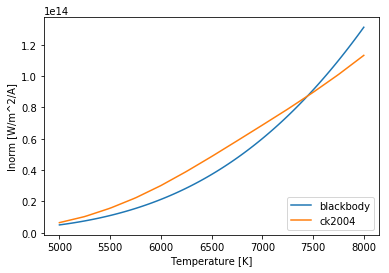

In [13]:
loggs = np.ones(len(teffs))*4.43
abuns = np.zeros(len(teffs))
plt.xlabel('Temperature [K]')
plt.ylabel('Inorm [W/m^2/A]')
plt.plot(teffs, pb.Inorm(teffs,               atm='blackbody', ld_func='linear', ld_coeffs=[0.0]), label='blackbody')
plt.plot(teffs, pb.Inorm(teffs, loggs, abuns, atm='ck2004',    ld_func='linear', ld_coeffs=[0.0]), label='ck2004')
plt.legend(loc='lower right')
plt.show()

Quite a difference. That is why using model atmospheres is superior when accuracy is of importance. Next, we need to compute direction-dependent intensities for all our limb darkening and boosting needs. This is a step that takes a long time; depending on your computer speed, it can take a few hours to complete.

In [14]:
pb.compute_ck2004_intensities(path='ck2004i', verbose=False)

/usr/local/lib/python2.7/dist-packages/phoebe/atmospheres/passbands.py:471: RankWarning: The fit may be poorly conditioned
  envelope = np.polynomial.legendre.legfit(lnwl, lnfl, 5)
/usr/local/lib/python2.7/dist-packages/phoebe/atmospheres/passbands.py:480: RankWarning: The fit may be poorly conditioned
  envelope = np.polynomial.legendre.legfit(lnwl[clipped], lnfl[clipped], 5)


This step will allow PHOEBE to compute all direction-dependent intensities on the fly, including the interpolation of the limb darkening coefficients that is model-independent. When limb darkening models are preferred (for example, when you don't quite trust direction-dependent intensities from the model atmosphere), we need to calculate two more tables: one for limb darkening coefficients and the other for the integrated limb darkening. That is done by two methods that do not take appreciable time to complete:

In [15]:
pb.compute_ck2004_ldcoeffs()
pb.compute_ck2004_ldints()

This completes the computation of Castelli & Kurucz auxiliary tables.

Importing Wilson-Devinney response
---------------------------------------

PHOEBE no longer shares any codebase with the WD code, but for comparison purposes it is sometimes useful to use the same atmosphere tables. If the passband you are registering with PHOEBE has been defined in WD's atmcof.dat and atmcofplanck.dat files, PHOEBE can import those coefficients and use them to compute intensities.

To import a set of WD atmospheric coefficients, you need to know the corresponding index of the passband (you can look it up in the WD user manual available at ftp://ftp.astro.ufl.edu/pub/wilson/lcdc2003/ebdoc2003.2feb2004.pdf.gz) and you need to grab the files ftp://ftp.astro.ufl.edu/pub/wilson/lcdc2003/atmcofplanck.dat.gz and ftp://ftp.astro.ufl.edu/pub/wilson/lcdc2003/atmcof.dat.gz from Bob Wilson's webpage. For this particular passband the index is 22. To import, issue:

In [16]:
pb.import_wd_atmcof('atmcofplanck.dat', 'atmcof.dat', 22)

We can consult the `content` attribute to see the entire set of supported tables, and plot different atmosphere models for comparison purposes:

In [17]:
print pb.content

['blackbody', 'ck2004', 'ck2004_all', 'ck2004_ld', 'ck2004_ldint', 'extern_planckint', 'extern_atmx']


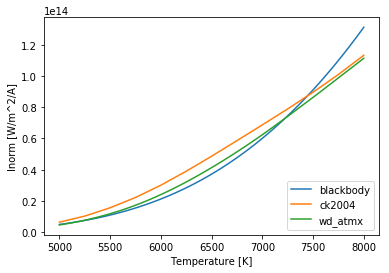

In [18]:
plt.xlabel('Temperature [K]')
plt.ylabel('Inorm [W/m^2/A]')
plt.plot(teffs, pb.Inorm(teffs,               atm='blackbody',   ld_func='linear', ld_coeffs=[0.0]), label='blackbody')
plt.plot(teffs, pb.Inorm(teffs, loggs, abuns, atm='ck2004',      ld_func='linear', ld_coeffs=[0.0]), label='ck2004')
plt.plot(teffs, pb.Inorm(teffs, loggs, abuns, atm='extern_atmx', ld_func='linear', ld_coeffs=[0.0]), label='wd_atmx')
plt.legend(loc='lower right')
plt.show()

Still an appreciable difference. This hopefully illustrates why excrutiating caution should be exercised at all times when dealing with modeling radiation.

Saving the passband table
-----------------------------

The final step of all this (computer's) hard work is to save the passband file so that these steps do not need to be ever repeated. From now on you will be able to load the passband file explicitly and PHOEBE will have full access to all of its tables. Your new passband will be identified as `'Custom:mypb'`.

In [19]:
pb.save('my_passband.pb')

To make PHOEBE automatically load the passband, add it to the `phoebe/atmospheres/tables/passbands` directory. If there are no proprietary aspects that hinder the dissemination of the tables, please consider contributing them to PHOEBE so that other users can use them.